#Automatic Brain Tumor Detection and Semantic Segmentation Using U-Net Loss Jacard Metric Iou
Mohammad Reza Tabrizi

#Importar dados
##A seguinte função auxilia na importação dos dados recolhidos dos vários repositórios, associando a respetiva label aos mesmos. Os dados são convertidos em arrays:

In [1]:
from google.colab import files
uploaded = files.upload()

Saving lgg-mri-segmentation.zip to lgg-mri-segmentation (1).zip


In [2]:
import zipfile
import io
data = zipfile.ZipFile(io.BytesIO(uploaded['lgg-mri-segmentation.zip']), 'r')
data.extractall()

In [3]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from tqdm import tqdm
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Importar dados
### A seguinte função auxilia na importação dos dados recolhidos dos vários repositórios, associando a respetiva label aos mesmos. Os dados são convertidos em arrays:

In [4]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [5]:
train_files = []
mask_files = glob('/content/lgg-mri-segmentation/kaggle_3m/*/*_mask*')

for i in mask_files:
    train_files.append(i.replace('_mask',''))

print(train_files[:10])
print(mask_files[:10])

['/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_14.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_21.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_16.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_1.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_31.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_18.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_20.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_15.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_30.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_4.tif']
['/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TW_199802

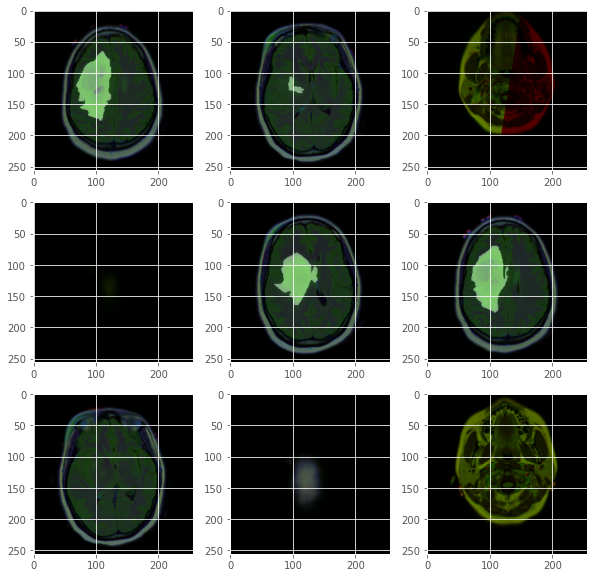

In [6]:
rows,cols=3,3
fig=plt.figure(figsize=(10,10))
for i in range(1,rows*cols+1):
    fig.add_subplot(rows,cols,i)
    img_path=train_files[i]
    msk_path=mask_files[i]
    img=cv2.imread(img_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    msk=cv2.imread(msk_path)
    plt.imshow(img)
    plt.imshow(msk,alpha=0.4)
plt.show()

In [7]:
df = pd.DataFrame(data={"filename": train_files, 'mask' : mask_files})

In [8]:
df.head()

,filename,mask
0,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...
1,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...
2,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...
3,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...
4,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...


In [9]:
X_train = np.zeros((len(df), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(df), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

In [10]:

for i in tqdm(range (len(df))):
    img_path=train_files[i]
    img=cv2.imread(img_path)[:,:,:IMG_CHANNELS] 
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[i] = img
    msk_path=mask_files[i]
    mask_ =cv2.imread(msk_path)
    mask_ = rgb2gray(mask_)
    mask_.shape
    mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',  
                              preserve_range=True), axis=-1)
    Y_train[i] = mask_

100%|██████████| 3929/3929 [00:56<00:00, 69.06it/s]


In [11]:
print(X_train.shape)
print(Y_train.shape)

(3929, 128, 128, 3)
(3929, 128, 128, 1)


In [12]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)
print(X_train1.shape)
print(X_test1.shape)

(3536, 128, 128, 3)
(393, 128, 128, 3)


# Sanety check, View few Images

<function matplotlib.pyplot.show>

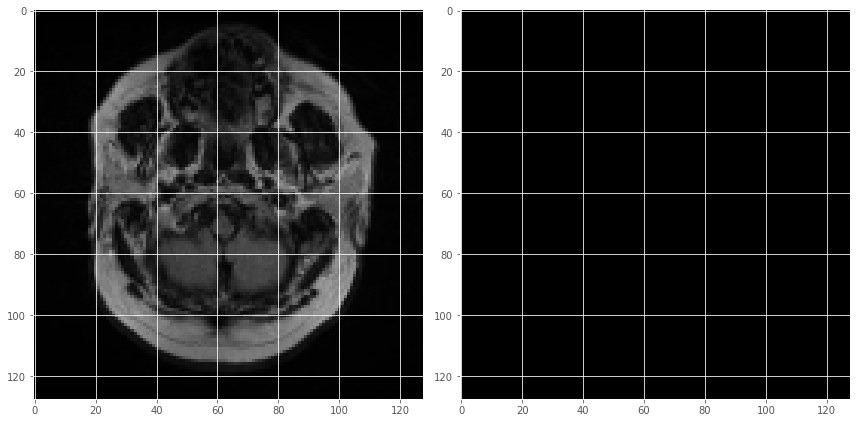

In [13]:
image_number = random.randint(0,len(X_train1))
plt.figure(figsize=(12,6))
plt.subplot(121)
imshow(X_train1[image_number])
plt.subplot(122)
imshow(np.squeeze(y_train1[image_number]))
plt.show

#As funções seguintes apresentam  configurações de redes neuronais UNet, a testar nas secções seguintes:

##Função de Jacard

In [14]:
smooth=0.000001
def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    intersection=K.sum(y_truef* y_predf)
    return((2.* intersection + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))
def dice_coef_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return 1 -dice_coef(y_true, y_pred)


In [15]:
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jacard_coef_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return -jacard_coef(y_true, y_pred)  # -1 ultiplied as we want to minimize this value as loss function

In [16]:
def jaccard_distance(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

def dice_coef_loss(y_true, y_pred):
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.cast(y_pred, tf.float32)
  return 1 -dice_coef(y_true, y_pred)

In [17]:
def dice_coef(y_true, y_pred, smooth=0.01):
  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
  return dice

def dice_coef_loss(y_true, y_pred):
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.cast(y_pred, tf.float32)
  return 1 -dice_coef(y_true, y_pred)

In [18]:
smooth=0.010

def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

def dice_coef_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)

    return - iou(y_true, y_pred)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

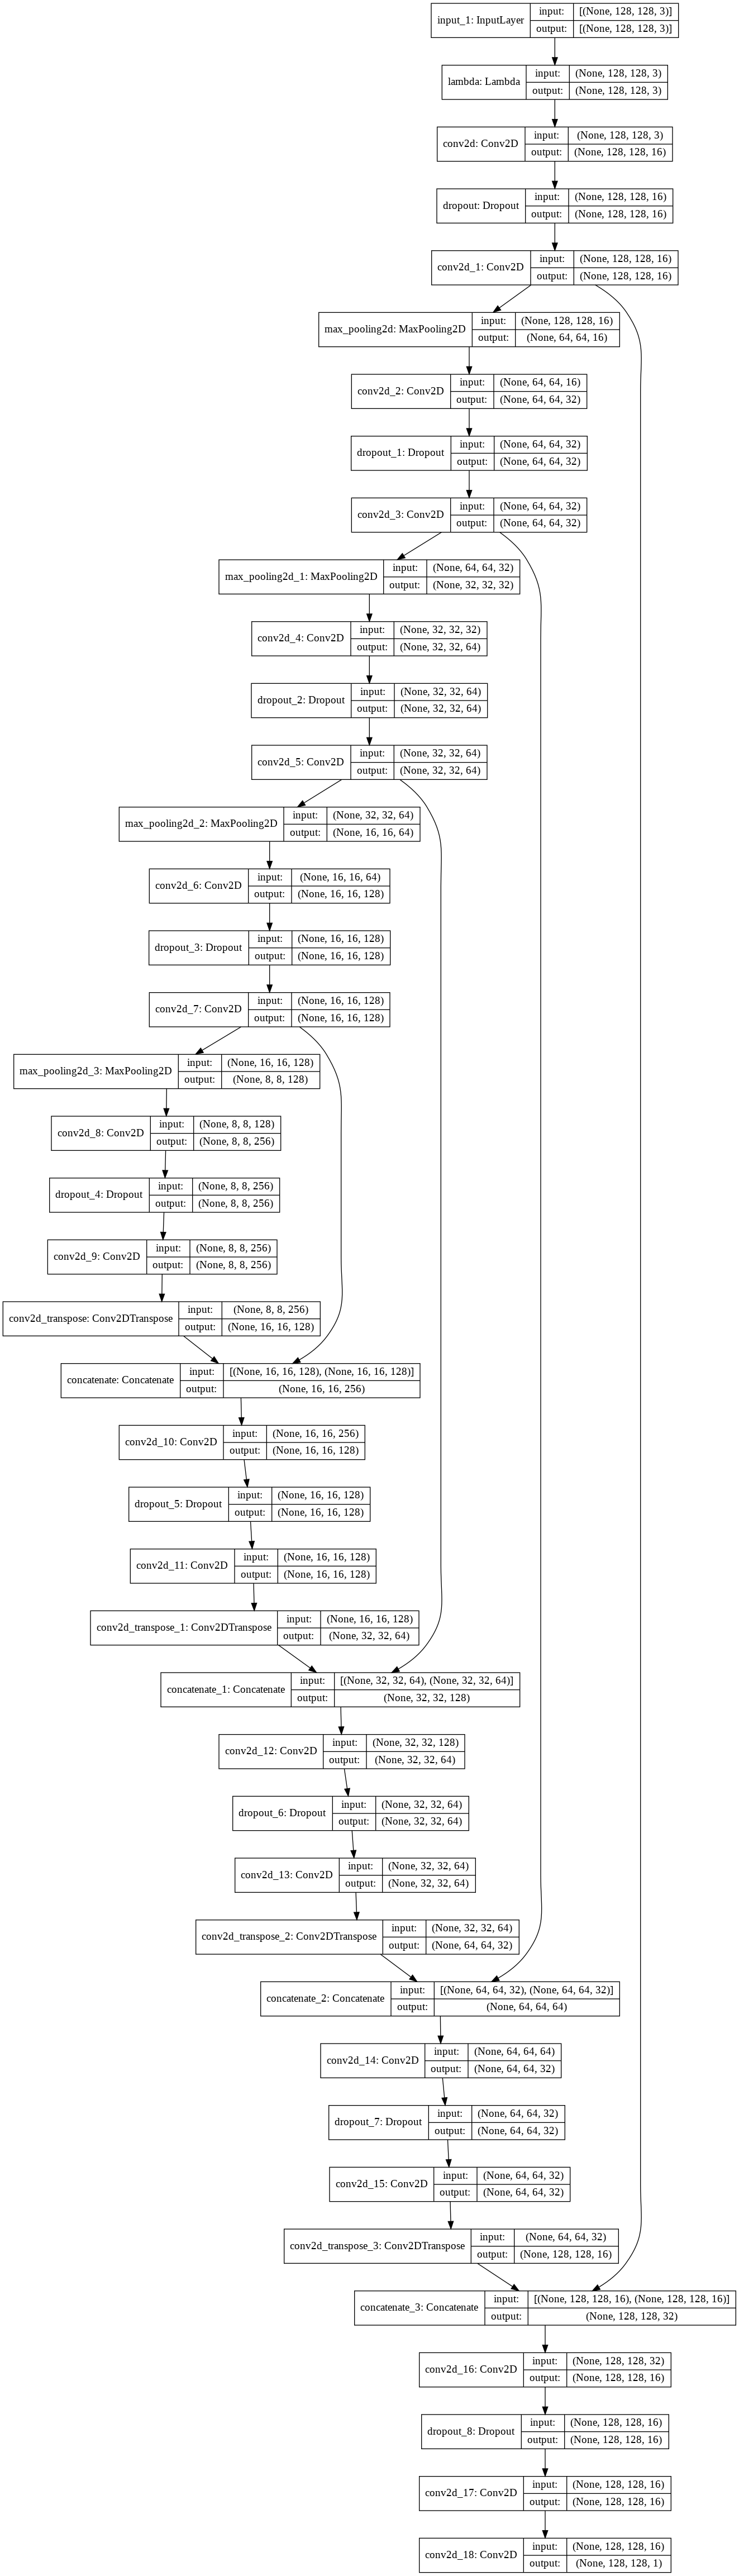

In [19]:
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model_jacard1 = tf.keras.Model(inputs=[inputs], outputs=[outputs])
opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
model_jacard1.compile(optimizer=opt,loss = [dice_coef_loss], metrics=[iou])

model_jacard1.summary()
tf.keras.utils.plot_model(model_jacard1, "simple_unet_model_jacard.png", show_shapes = True)



In [20]:
#Modelcheckpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint('simple_unet_model_jacard.h5', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]
history_jacard = model_jacard1.fit(X_train1, y_train1,
                    batch_size= 16,
                    verbose= 1,
                    epochs= 100,
                    validation_data= (X_test1,y_test1),
                    shuffle=False,
                    callbacks=callbacks)

Epoch 1/100
221/221 [==============================] - 38s 28ms/step - loss: -0.0292 - iou: 0.0148 - val_loss: -0.0342 - val_iou: 0.0174
Epoch 2/100
221/221 [==============================] - 5s 23ms/step - loss: -0.0797 - iou: 0.0428 - val_loss: -0.0872 - val_iou: 0.0458
Epoch 3/100
221/221 [==============================] - 5s 23ms/step - loss: -0.2398 - iou: 0.1404 - val_loss: -0.0925 - val_iou: 0.0487
Epoch 4/100
221/221 [==============================] - 5s 23ms/step - loss: -0.2928 - iou: 0.1778 - val_loss: -0.0945 - val_iou: 0.0499
Epoch 5/100
221/221 [==============================] - 5s 23ms/step - loss: -0.3301 - iou: 0.2056 - val_loss: -0.1011 - val_iou: 0.0536
Epoch 6/100
221/221 [==============================] - 5s 23ms/step - loss: -0.3651 - iou: 0.2330 - val_loss: -0.0988 - val_iou: 0.0523
Epoch 7/100
221/221 [==============================] - 5s 23ms/step - loss: -0.3966 - iou: 0.2574 - val_loss: -0.1080 - val_iou: 0.0576
Epoch 8/100
221/221 [==========================

In [21]:
y_pred = model_jacard1.predict(X_test1,verbose=0)
y_pred_trasholded = y_pred > 0.5

intersection = np.logical_and(y_test1, y_pred_trasholded)
union = np.logical_or(y_test1,y_pred_trasholded)
iou_score = np.sum(intersection)/ np.sum(union)
print ("IoU score is: ",iou_score)

IoU score is:  0.6016063737227747


In [22]:
history_jacard.history.keys()

dict_keys(['loss', 'iou', 'val_loss', 'val_iou'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


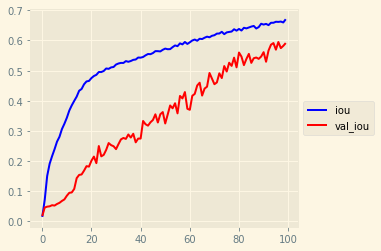

In [23]:
with plt.style.context('Solarize_Light2'):
  plt.plot((history_jacard.history['iou']),label='iou', linestyle='-', color='b')
  plt.plot((history_jacard.history['val_iou']),label='val_iou', linestyle='-', color='r')
  ax = plt.subplot(111)
  box = ax.get_position()
  ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
  ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    #plt.legend(loc='best')

plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


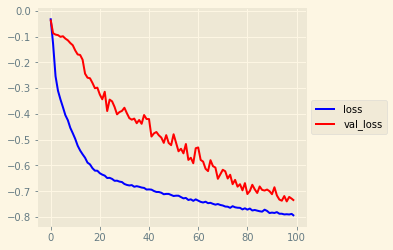

In [24]:
with plt.style.context('Solarize_Light2'):
  plt.plot((history_jacard.history['loss']),label='loss', linestyle='-', color='b')
  plt.plot((history_jacard.history['val_loss']),label='val_loss', linestyle='-', color='r')
  ax = plt.subplot(111)
  box = ax.get_position()
  ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
  ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    #plt.legend(loc='best')

plt.show()

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


<function matplotlib.pyplot.show>

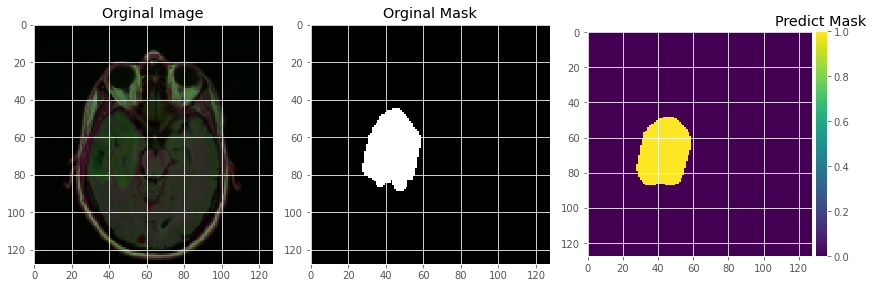

In [34]:
preds_test_t = (y_pred > 0.5).astype(np.uint8)

ix = random.randint(0, len(preds_test_t))
plt.figure(figsize=(12,6))
plt.subplot(131)
imshow(X_test1[ix])
plt.title('Orginal Image')
plt.subplot(132)
imshow(np.squeeze(y_test1[ix]))
plt.title('Orginal Mask')
plt.subplot(133)
imshow(np.squeeze(preds_test_t[ix]))
plt.title('Predict Mask')
plt.show